In [205]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Wed Nov 07 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [247]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/nolds/__init__.py
Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-247-2bbca3de3ee5>:28: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [241]:
def prepare_dfs(col='lyap'):
    df_X = pd.read_pickle(os.path.join(LABELED_ROOT, 'splits.pickle'))
    df_X = df_X.loc[:, (slice(None), [4], slice(None))].unstack().dropna()[col][4]
    df_X = df_X.astype(float)
    df_yr = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_response.pickle'))
    df_yr.columns = ['label_r']
    df_yd = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels_depressed.pickle'))
    df_yd.columns = ['label_d']
    df_y = df_yr.join(df_yd)
    df = df_X.join(df_y)
    rows = [row for row in df_X.index if row[0].startswith('b')]
    df_aft = df_X.loc[rows, :].join(df_y)
    df_aft.index = df_aft.index.map(lambda t: int(t.split('-')[1]))
    df_aft = df_aft.sort_index()
    rows = [row for row in df_X.index if row[0].startswith('a')]
    df_bef = df_X.loc[rows, :].join(df_y)
    df_bef.index = df_bef.index.map(lambda t: int(t.split('-')[1]))
    df_bef = df_bef.sort_index()
    return df, df_bef, df_aft
df, df_bef, df_aft = prepare_dfs()

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [242]:
extra = pd.DataFrame(index=df.index, columns=['age', 'sex', 'freq', 'sc_bef', 'sc_aft'])
for name, row in extra.iterrows():
    extra.loc[name, 'age'] = meta_df.loc[int(row.name.split('-')[1]), 'AGE']
    extra.loc[name, 'sex'] = meta_df.loc[int(row.name.split('-')[1]), 'SEX']
    extra.loc[name, 'freq'] = 0 if meta_df.loc[int(row.name.split('-')[1]), 'freq'] == 250 else 1
    extra.loc[name, 'sc_bef'] = meta_df.loc[int(row.name.split('-')[1]), 'M_1']
    extra.loc[name, 'sc_aft'] = meta_df.loc[int(row.name.split('-')[1]), 'M_4']

df_ext = df.join(extra)
df_ext.to_csv(os.path.join(LABELED_ROOT, 'splits_ext.csv'), encoding='utf-8')
df_ext

,"(lyap, 4, C3)","(lyap, 4, C4)","(lyap, 4, Cz)","(lyap, 4, F3)","(lyap, 4, F4)","(lyap, 4, F7)","(lyap, 4, F8)","(lyap, 4, FP1)","(lyap, 4, FP2)","(lyap, 4, Fz)",...,"(hurst, 4, T4)","(hurst, 4, T5)","(hurst, 4, T6)",label_r,label_d,age,sex,freq,sc_bef,sc_aft
trial,,,,,,,,,,,,,,,,,,,,,
a-1,0.045364,0.067452,0.050856,0.069753,0.047434,-0.001260,0.023015,0.030176,0.001346,0.024992,...,0.696895,0.732276,0.685362,1,M,49,0,0,26,13
a-10,0.040702,0.047999,0.048087,0.064798,0.065421,0.062461,0.044014,0.068277,0.059475,0.047351,...,0.600445,0.568884,0.595361,1,H,49,0,0,36,17
a-102,0.038197,0.038800,0.040129,0.036012,0.037527,0.041671,0.040425,0.038816,0.038974,0.038513,...,0.631765,0.519470,0.544728,1,L,56,1,0,18,6
a-104,0.043323,0.050189,0.046985,0.062458,0.043751,0.045558,0.033362,0.063719,0.041180,0.040471,...,0.552185,0.655248,0.323342,1,H,64,0,0,32,2
a-105,0.056602,0.057485,0.061258,0.055412,0.061162,0.057670,0.060052,0.019251,0.030407,0.058691,...,0.754046,0.616085,0.649632,1,H,46,0,0,30,1
a-106,0.044843,0.031342,0.035743,0.044686,0.042449,0.027451,0.030340,0.061954,0.062641,0.035479,...,0.732967,0.747377,0.709226,1,H,35,0,0,31,7
a-107,0.035446,0.036872,0.036262,0.030599,0.031418,0.044002,0.039282,0.045442,0.042117,0.038398,...,0.590088,0.415728,0.573222,1,M,63,1,0,25,12
a-108,0.051002,0.047751,0.047776,0.048295,0.049516,0.047220,0.044640,0.046374,0.029891,0.049207,...,0.640643,0.621692,0.580595,1,H,65,0,0,27,11
a-109,0.046345,0.047241,0.035678,0.045575,0.046509,0.029587,0.036592,0.038618,0.037900,0.036718,...,0.639410,0.605590,0.547863,0,H,37,0,0,28,18


# Before and after comparison plots

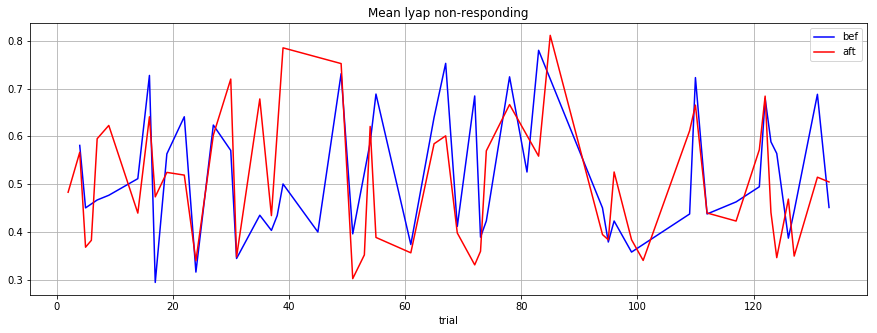

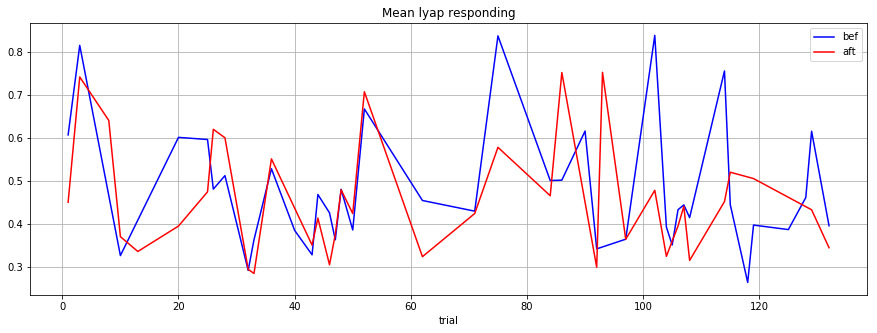

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


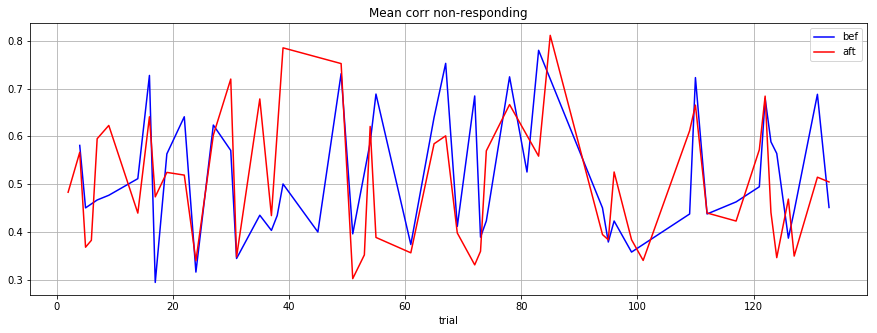

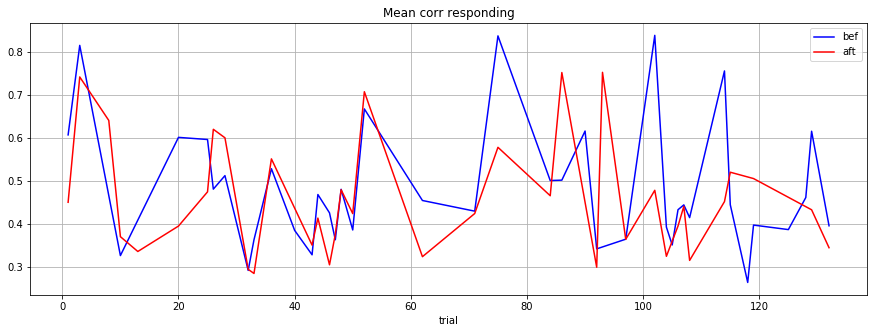

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


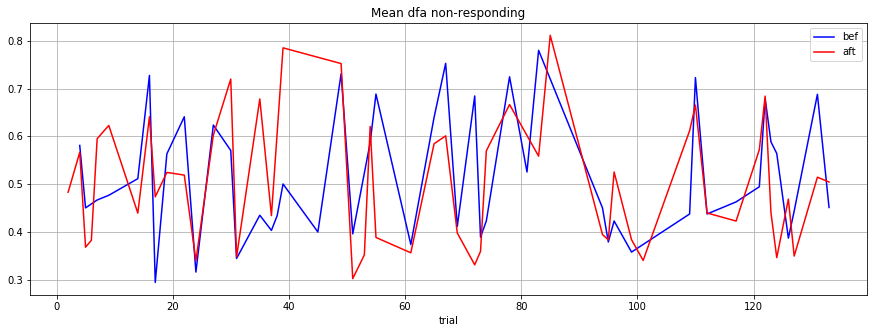

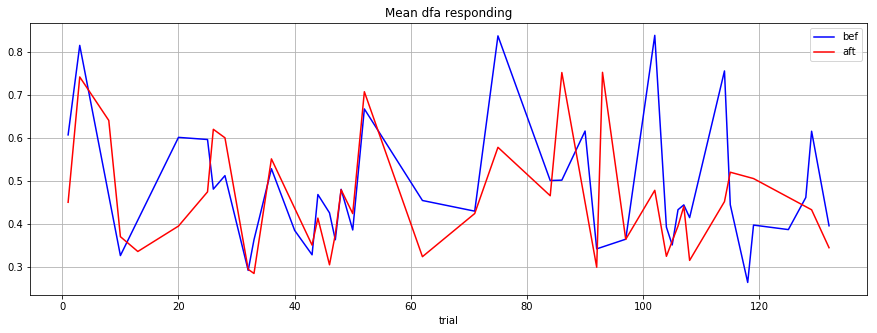

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


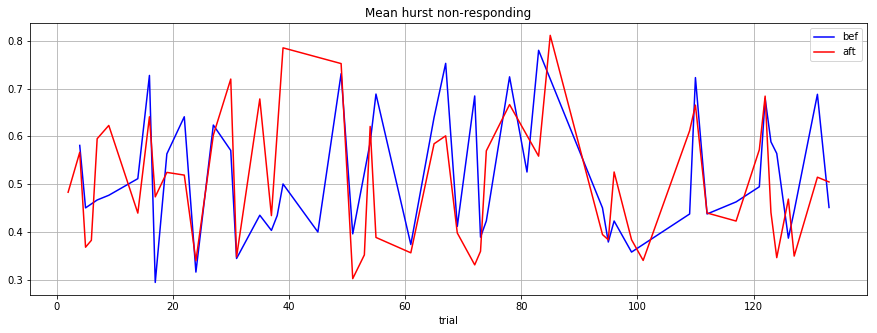

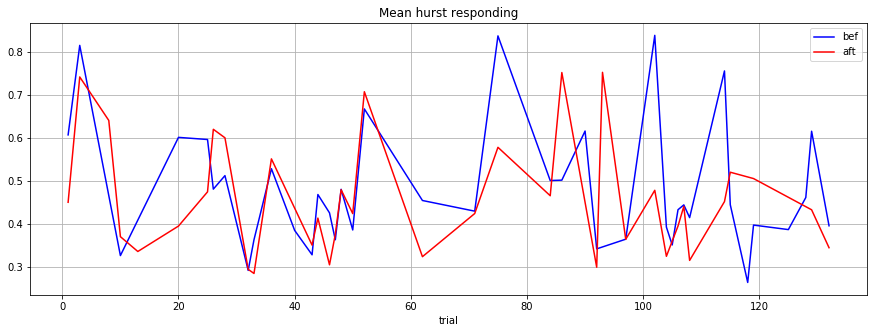

/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/home/miroslav/anaconda3/envs/thesis/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [246]:
def plot_resp(df_bef, df_aft, m_name, resp):
    means_bef = df_bef[df_bef['label_r']==resp].mean(axis=1)
    means_aft = df_aft[df_aft['label_r']==resp].mean(axis=1)
    plt.figure(figsize=(15,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='bef')
    ax2 = means_aft.plot(color='red', grid=True, label='aft')
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0)
    plot_resp(df_bef, df_aft, m_name, 1)

for col in ['lyap', 'corr', 'dfa', 'hurst']:
    plot_measure(df_bef, df_aft, col)
    df, df_bef, df_aft = prepare_dfs(col)

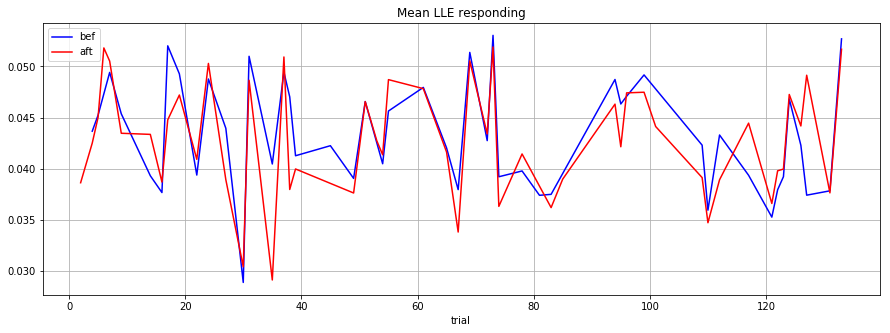

In [202]:
means_bef = df_bef[df_bef['label_r']==0].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==0].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.title('Mean LLE responding')
plt.show()

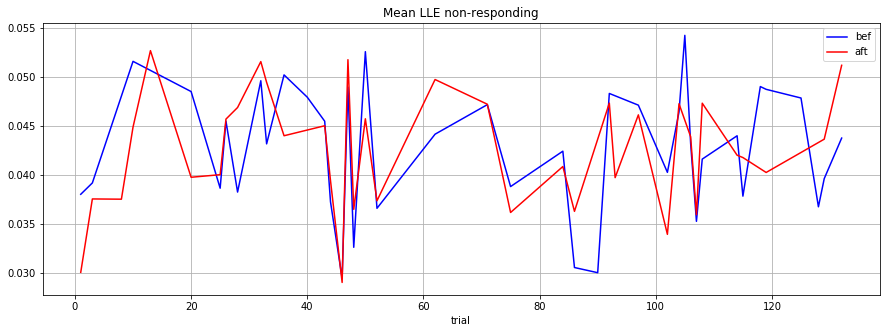

In [203]:
means_bef = df_bef[df_bef['label_r']==1].mean(axis=1)
means_aft = df_aft[df_aft['label_r']==1].mean(axis=1)
plt.figure(figsize=(15,5))
ax1 = means_bef.plot(color='blue', grid=True, label='bef')
ax2 = means_aft.plot(color='red', grid=True, label='aft')
plt.legend()
plt.title('Mean LLE non-responding')
plt.show()

# Before and after K-S test

In [204]:
from scipy.stats import ks_2samp

def print_res(name, res):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {}'.format(name, res.pvalue, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef.mean(axis=1), df_aft.mean(axis=1)))
    print_res('Stds', ks_2samp(df_bef.std(axis=1), df_aft.std(axis=1)))
    for col in df.loc[:, map(lambda c: not c.startswith('label'), df.columns)].columns:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]))
        

for col in ['lyap', 'corr', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE***')
for col in ['lyap', 'corr', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['label_d']=='L']
    high = df[df['label_d']=='H']
    channel_wise_ks(low, high)
    print()

LYAP
All
Means: 	 0.8432030762784873 	 
Stds: 	 0.043202177978732846 	 !!
C3: 	 0.47106582327896085 	 
C4: 	 0.7238980471658877 	 
Cz: 	 0.2699043637725488 	 
F3: 	 0.06537506455171255 	 !
F4: 	 0.8432030762784878 	 
F7: 	 0.8432030762784873 	 
F8: 	 0.5947978679590012 	 
FP1: 	 0.47106582327896085 	 
FP2: 	 0.9338851942783939 	 
Fz: 	 0.9338851942783939 	 
O1: 	 0.13940285283713824 	 
O2: 	 0.06537506455171255 	 !
P3: 	 0.06537506455171271 	 !
P4: 	 0.19637254341678279 	 
Pz: 	 0.9338851942783942 	 
T3: 	 0.09660834157339039 	 
T4: 	 0.9338851942783939 	 
T5: 	 0.3615587020083678 	 
T6: 	 0.0966083415733906 	 

Non-responding
Means: 	 0.9905859418347901 	 
Stds: 	 0.3396474310092137 	 
C3: 	 0.13980022836749284 	 
C4: 	 0.9848783913874158 	 
Cz: 	 0.5403765897440452 	 
F3: 	 0.4154786567825486 	 
F4: 	 0.7890910097768793 	 
F7: 	 0.8176968538177888 	 
F8: 	 0.5711847535674928 	 
FP1: 	 0.9494954474966849 	 
FP2: 	 0.3556642356008802 	 
Fz: 	 0.6129767887414205 	 
O1: 	 0.3017453390122

P4: 	 0.056943661227086294 	 !
Pz: 	 0.13641023059691487 	 
T3: 	 0.2901617192803718 	 
T4: 	 0.117537336455934 	 
T5: 	 0.117537336455934 	 
T6: 	 0.04026637909353969 	 !!



# PCA